<a href="https://colab.research.google.com/github/ykitaguchi77/ImageProcessing/blob/master/Bilateral_eye_crop1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・検出された目周囲の画像を縦横とも1.1倍の幅で切り抜く(2つ検出したときには2つの検出範囲の上端と下端を基準とする）
・切り取った画像を250px*250pxにresizeする<br>
・対応表をCSV形式で出力（連番、左右、元フォルダ、元画像名）

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import math

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!date -R
!unzip -qq drive/My\ Drive/Deep_learning/gravcont_original.zip
!date -R
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mon, 17 Feb 2020 02:31:10 +0000
Mon, 17 Feb 2020 02:31:23 +0000
cont  drive  grav  sample_data


In [0]:
#元画像フォルダ
in_path = '/content/cont'

#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/gravcont_processed/cont_processed'

#CSVファイルのフォルダ
csv_path = '/content/drive/My Drive/Deep_learning/gravcont_processed/cont_error.csv'


#Haarcascadeを指定

In [0]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#処理するdirectoryの設定
（画像が多い時には複数回に分ける）

In [46]:
#処理するDirectoryの設定
file = os.listdir(in_path)
print(len(file))

#ここにフォルダ番号を記載する (ex. [0:999])
processing_file = file[0:321]
print(processing_file)
len(processing_file)

321
['1116.jpg', '200.jpg', '130.jpg', '66.jpg', '137.jpg', '742.jpg', '1393.jpg', '476.jpg', '91.jpg', '388.jpg', '168.jpg', '1459.jpg', '1547.jpg', '542.jpg', '934.jpg', '854.jpg', '719.JPG', '678.jpg', '1414.jpg', '1014.JPG', '1404.JPG', '85.jpg', '444.jpg', '38.JPG', '1303.JPG', '1025.jpg', '1193.jpg', '1111.jpg', '1360.jpg', '87.JPG', '1305.jpg', '858.JPG', '172.jpg', '1023.jpg', '591.jpg', '402.JPG', '1000.jpg', '210.jpg', '776.jpg', '185.JPG', '726.jpg', '204.jpg', '1338.JPG', '1045.JPG', '932.JPG', '630.jpg', '1160.jpg', '209.jpg', '368.jpg', '1012.jpg', '439.JPG', '1222.JPG', '562.jpg', '98.jpg', '1043.jpg', '75.jpg', '145.JPG', '214.JPG', '1102.jpg', '1490.JPG', '253.JPG', '229.jpg', '495.JPG', '1029.jpg', '308.jpg', '1009.jpg', '513.jpg', '469.jpg', '881.JPG', '1082.jpg', '1424.JPG', '1494.jpg', '191.jpg', '1136.jpg', '362.jpg', '1318.jpg', '1094.JPG', '809.JPG', '110.jpg', '871.JPG', '1182.jpg', '1405.JPG', '1522.jpg', '186.jpg', '1220.jpg', '1515.jpg', '891.jpg', '1348.jpg

321

#画像切り抜き
大きい辺を1辺とする正方形に整形する

In [0]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width-height)//2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, (0, (height - width) // 2))
        return result

In [0]:
#処理時間の計測
start = time.time()

l=0
detection_error = []
for i in processing_file:
      l+=1
      print('')
      print(str(l))
      print(str(i))
      print('image path = '+ in_path + '/' + i)

      #OPEN CVで画像を読み込み
      img = cv2.imread(in_path + '/' + i) 
      
      # 画像グレースケール化
      grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      #100pix以上のもので目に見えるものを抽出
      eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
                    
      # 眼検出判定
      if len(eye_list) >= 1:
          print('目が' + str(len(eye_list)) +'個検出されました')
          if len(eye_list) > 2:
              detection_error.append(i) #3つ以上検出時には、画像処理は行うがerrorリストには加える
        
      elif len(eye_list) == 0:
          print("eye detection error")
          detection_error.append(i)
      
      #画像の切り抜きと保存
      if len(eye_list) >= 1:              
          ex_min, ey_min, ex_ew_max, ey_eh_max = 100000, 100000, 0, 0  #初期値を設定
          m=0
          for (ex, ey, ew, eh) in eye_list:
              m+=1
              #右眼の外上端、左眼の外下端の座標を取得
              ex_min, ey_min, ex_ew_max, ey_eh_max = min(ex_min, ex), min(ey_min, ey), max(ex_ew_max, ex+ew), max(ey_eh_max, ey+eh)
              print(ex_min, ey_min, ex_ew_max, ey_eh_max)
          img = Image.open(in_path + '/' + i)

          #横はイメージの幅に合わせて、縦は検出された目の縦幅の1.2倍の幅で切り抜く。その後に横辺250pixに縮小する
          #img_cropped = img.crop((int(ex_min), int(ey_min), int(ex_ew_max), int(ey_eh_max))) 
          img_cropped = img.crop((0, int(1.2*ey_min-0.2*ey_eh_max), img.width, int(-0.2*ey_min+1.2*ey_eh_max))) 
          img_new = expand2square(img_cropped, (0, 0, 0)).resize((250, 250))
          
          #切り取った画像を表示
          #plt.imshow(np.asarray(img_new))
          #plt.show()

          #ランダムな位置で224pixに切り取る
          #x, y = random.randint(0,27), random.randint(0,27) 
          #img_randcrop = img_resized[y: y+223, x: x+223]
          
          img_new.save(out_path +'/'+ str(i))
          print(out_path +'/'+ str(i))

print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print ("detection error:")
print (detection_error)


In [0]:
header = ['Number']

#with open(csv_path, 'a', newline='') as f:  #a:追記モード
with open(csv_path, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(detection_error)


#切り取られた図を表示してみる

['1116.jpg', '200.jpg', '137.jpg', '742.jpg', '476.jpg', '91.jpg', '388.jpg', '1547.jpg', '1414.jpg', '168.jpg', '542.jpg', '1014.JPG', '1459.jpg', '934.jpg', '1404.JPG', '85.jpg', '854.jpg', '444.jpg', '719.JPG', '38.JPG', '678.jpg', '1303.JPG', '1025.jpg', '87.JPG', '1193.jpg', '1305.jpg', '1111.jpg', '172.jpg', '1360.jpg', '1023.jpg', '402.JPG', '1000.jpg', '210.jpg', '776.jpg', '726.jpg', '185.JPG', '204.jpg', '1338.JPG', '1045.JPG', '932.JPG', '630.jpg', '1160.jpg', '209.jpg', '368.jpg', '1012.jpg', '1222.JPG', '439.JPG', '562.jpg', '1043.jpg', '98.jpg', '145.JPG', '214.JPG', '1102.jpg', '1490.JPG', '253.JPG', '229.jpg', '495.JPG', '1029.jpg', '308.jpg', '1494.jpg', '513.jpg', '881.JPG', '1424.JPG', '1136.jpg', '362.jpg', '1318.jpg', '1094.JPG', '809.JPG', '1522.jpg', '110.jpg', '186.jpg', '871.JPG', '1220.jpg', '1182.jpg', '1515.jpg', '1405.JPG', '891.jpg', '620.jpg', '1348.jpg', '685.jpg', '689.jpg', '410.JPG', '1461.jpg', '1473.JPG', '398.jpg', '1541.jpg', '745.jpg', '1256.JPG'

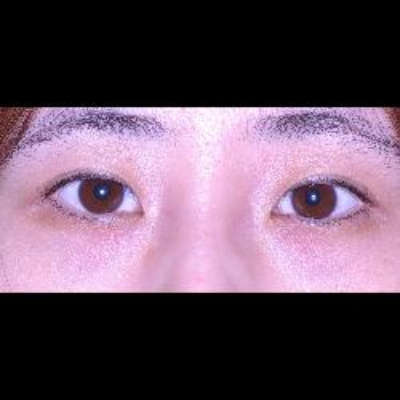

In [50]:
img_list = os.listdir(out_path)
print(img_list)
img = cv2.imread(out_path +'/'+ file[1])

#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)
dst = scale_to_width(img, 400)

#図を表示する
cv2_imshow(dst)